### Pipeline sur l'image des lolipop pour extraire les PM

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath("../../"))
from pipeoptz import Pipeline, Node
sys.path.append(os.path.abspath("../../../GLACIS-lib_image_analysis/"))
from image_analysis import image_processing, models, utils, mask_utils

In [2]:
def load_image(path):
    return np.array(Image.open(path))

def color_elements(image, mask):
    return image * mask[:, :, np.newaxis]

def head_tail_link(masks):
    m = sorted(masks, key=lambda m: m['area'], reverse=True)
    if len(m) < 2:
        return None
    m1, m2 = m[:2]
    print(len(masks))
    print()
    return mask_utils.find_link_point(m1["segmentation"], m2["segmentation"])

In [3]:
p = Pipeline("Lolipop")
p.add_node(Node("Load Image", load_image, fixed_params={"path": "../../image/canvas.png"}))
p.add_node(Node("Palette", image_processing.extract_palette, fixed_params={"n_colors": 9}), predecessors={"image": "Load Image"})
p.add_node(Node("Recolor", image_processing.recolor), predecessors={"image": "Load Image", "palette": "Palette"})
p.add_node(Node("Remove Background", image_processing.remove_palette, fixed_params={"indices_to_remove": (0, 1, 2)}), predecessors={"image": "Load Image", "palette": "Palette", "recolored_image": "Recolor"})
p.add_node(Node("Concatenate", image_processing.concatenate, fixed_params={"radius": 1}), predecessors={"image":"Remove Background"})
p.add_node(Node("Isolate Elements", image_processing.isolate, fixed_params={"sizemin": 600}), predecessors={"binary_mask": "Concatenate"})
p.add_node(Node("Elements Coords", utils.get_pos, fixed_params={"bonus": 5}), predecessors={"[el]": "Isolate Elements"})

p.add_node(Node("Load SAM", models.load_SAM, fixed_params={"model_type": "small", "use_gpu": False}))
p.add_node(Node("Load Predictor", models.load_predictor, fixed_params={"is_sam2": True}), predecessors={"image": "Load Image", "sam_model": "Load SAM"})
p.add_node(Node("Affinate Elements", models.predict_masks_SAM), predecessors={"sam_predictor": "Load Predictor", "[box_coord]": "Elements Coords"})
p.add_node(Node("Colored Elements", color_elements), predecessors={"[image]": "Load Image", "[mask]": "Affinate Elements"})
p.add_node(Node("Min Size", image_processing.min_size), predecessors={"[image]": "Colored Elements"})
p.add_node(Node("Remove Alpha", image_processing.remove_alpha), predecessors={"[image]": "Min Size"})

p.add_node(Node("Masks Generator", models.create_mask_generator, fixed_params={"points_per_side":1, "is_sam2": True}), predecessors={"sam_model": "Load SAM"})
p.add_node(Node("Generate Masks", lambda image, mask_generator: mask_generator.generate(image)), predecessors={"[image]": "Remove Alpha", "mask_generator": "Masks Generator"})
#p.add_node(Node("Masks Selection", mask_utils.masks_selection), predecessors={"[masks]": "Generate Masks", "[image]": "Min Size"})
p.add_node(Node("Link Points", head_tail_link), predecessors={"[masks]": "Generate Masks"})


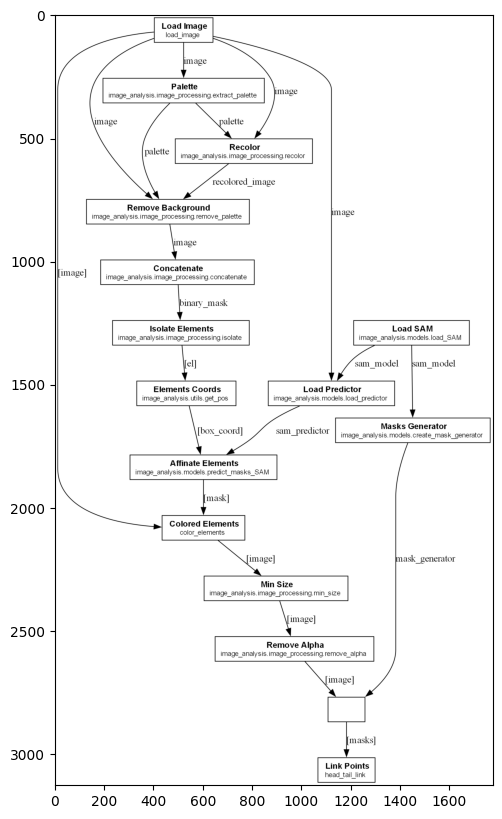

In [4]:
p.to_dot("lolipop.dot", generate_png=True)
plt.figure(figsize=(10, 10))
plt.imshow(Image.open("lolipop.png"))

# ATTENTION
L'exécution de cette pipeline est longue (10 à 20min)

In [ ]:
index, res, timer = p.run(skip_failed_images=True, debug=True)
timer